# GEOG489 SP22 Final

## Instruction
Your final exam consists of three major parts. <br>
**First**, you will prepare supply, demand, and mobility data for measuring spatial accessibility to healthcare resources in Champaign County. <br>
**Second**, you will measure spatial accessibility considering distance decay. <br>
**Third**, you will calculate spatial autocorrelation based on the accessibility measures.
<br><br>
**When you finish the task, please save/download your Jupyter notebook and submit it to learn.illinois.edu.**

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import esda
import libpysal

# 1. Data preprocessing (3 points)
## 1.1. Supply (1 point)
* Load `healthcare.shp` in the data folder and name it as `supply`. 
* Create a column named `weight` and assign weights based on `TYPE` of healthcare (10 for `Hospital` and 5 for `Urgent Care`). 
* Change the coordinate system of the dataframe to State Plane Coordinate System - Illinois East (NAD83) (epsg:26971).
<br><br>

**Note**: The below is the expected result. 
<img src="./images/supply.jpg" width="60%"/>

In [2]:
# Your code here
supply = gpd.read_file('./data/healthcare.shp')

supply['weight'] = 0.0
for idx, row in supply.iterrows():
    if row['TYPE'] == 'Hospital':
        supply.at[idx, 'weight'] = 10
    elif row['TYPE'] == 'Urgent Care':
        supply.at[idx, 'weight'] = 5
        
supply = supply.to_crs(epsg=26971)
supply.head()

,NAME,TYPE,geometry,weight
0,THE CARLE FOUNDATION HOSPITAL,Hospital,POINT (310091.878 383002.829),10.0
1,THE PAVILION FOUNDATION,Hospital,POINT (306461.377 383072.805),10.0
2,OSF HEALTHCARE SYSTEM HEART OF MARY MEDICAL CE...,Hospital,POINT (309055.291 383104.709),10.0
3,CHRISTIE CLINIC AT COUNTY MARKET - GLENN PARK ...,Urgent Care,POINT (304602.020 383319.726),5.0
4,CHRISTIE CLINIC AT COUNTY MARKET - CORNER OF K...,Urgent Care,POINT (303323.118 380721.694),5.0


## 1.2. Demand (1 point)
* With `census_block_groups.shp` and `pop_census.csv` in the data folder, create a GeoDataFrame named `demand` by merging them based on a column that shares information between them.
* Drop the `GEO_ID` column after the merge. 
* Change the coordinate system of the dataframe to State Plane Coordinate System - Illinois East (NAD83) (epsg:26971).
<br><br>

**Note**: The below is the expected result. 
<img src="./images/demand.jpg" width="40%"/>

In [3]:
# Your code here
bg = gpd.read_file('./data/census_block_groups.shp')
census = pd.read_csv('./data/pop_census.csv')
census['GEOID'] = census.apply(lambda x:x['GEO_ID'][9:], axis=1)
demand = bg.merge(census, on='GEOID')
demand = demand.drop(columns=['GEO_ID'])
demand = demand.to_crs(epsg=26971)

demand.head()

,GEOID,geometry,pop
0,170190008004,"POLYGON ((306407.568 387381.633, 306409.506 38...",1554
1,170190109021,"POLYGON ((301663.744 375331.378, 301664.492 37...",1719
2,170190014003,"POLYGON ((307179.741 377349.506, 307179.910 37...",2145
3,170190008003,"POLYGON ((304790.796 387513.235, 304795.054 38...",1308
4,170190109023,"POLYGON ((288952.382 366354.051, 289005.181 36...",747


## 1.3. Mobility (1 point)

* Utilize `OSMnx` package to obtain road network for `Champaign County` and assign the result to a variable `G`.
* Project the road network to State Plane Coordinate System - Illinois East (NAD83) (epsg:26971).
* Utilize the `remove_uncenessary_nodes` function below, and remove unnecessary nodes from the imported road network. 
```python
def remove_uncenessary_nodes(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg == 0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg == 0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component) < 30:
            for node in component:
                _nodes_removed += 1
                network.remove_node(node)

    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed / float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))

    return network
```

In [4]:
def remove_uncenessary_nodes(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg == 0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg == 0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component) < 30:
            for node in component:
                _nodes_removed += 1
                network.remove_node(node)

    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed / float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))

    return network

# Your code here
G = ox.graph_from_place('Champaign County, IL, USA', network_type='drive', simplify=True)
G = ox.project_graph(G, to_crs='epsg:26971')

G = remove_uncenessary_nodes(G)


/Users/jparkgeo/opt/anaconda3/envs/sa/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


Removed 24 nodes (0.0027%) from the OSMNX network
Number of nodes: 9035
Number of edges: 25835


# 2. Measuring accessibility to healthcare resources (5 points)

## 2.1. Find the nearest OSM node from `supply` and `demand`. (1 point)

* Use the following `find_nearest_osm` function to search the nearest OSM node from `supply` and `demand` GeoDataFrame, respectively.
```python
def find_nearest_osm(network, gdf):
    """
    # This function helps you to find the nearest OSM node from a given GeoDataFrame
    # If geom type is point, it will take it without modification, but 
    # IF geom type is polygon or multipolygon, it will take its centroid to calculate the nearest element. 
    
    Input: 
    - network (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - gdf (GeoDataFrame): stores locations in its `geometry` column 
    
    Output:
    - gdf (GeoDataFrame): will have `nearest_osm` column, which describes the nearest OSM node 
                          that was computed based on its geometry column
      
    """
    for idx, row in gdf.iterrows():
        if row.geometry.geom_type == 'Point':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                                    X=row.geometry.x, 
                                                    Y=row.geometry.y
                                                   )
        elif row.geometry.geom_type == 'Polygon' or row.geometry.geom_type == 'MultiPolygon':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                        X=row.geometry.centroid.x, 
                                        Y=row.geometry.centroid.y
                                       )
        else:
            print(row.geometry.geom_type)
            continue

        gdf.at[idx, 'nearest_osm'] = nearest_osm

    return gdf
```

In [5]:
# Your code here

def find_nearest_osm(network, gdf):
    """
    # This function helps you to find the nearest OSM node from a given GeoDataFrame
    # If geom type is point, it will take it without modification, but 
    # IF geom type is polygon or multipolygon, it will take its centroid to calculate the nearest element. 
    
    Input: 
    - network (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - gdf (GeoDataFrame): stores locations in its `geometry` column 
    
    Output:
    - gdf (GeoDataFrame): will have `nearest_osm` column, which describes the nearest OSM node 
                          that was computed based on its geometry column
      
    """
    for idx, row in gdf.iterrows():
        if row.geometry.geom_type == 'Point':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                                    X=row.geometry.x, 
                                                    Y=row.geometry.y
                                                   )
        elif row.geometry.geom_type == 'Polygon' or row.geometry.geom_type == 'MultiPolygon':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                        X=row.geometry.centroid.x, 
                                        Y=row.geometry.centroid.y
                                       )
        else:
            print(row.geometry.geom_type)
            continue

        gdf.at[idx, 'nearest_osm'] = nearest_osm

    return gdf


supply = find_nearest_osm(G, supply)
demand = find_nearest_osm(G, demand)

## 2.2. Calculate estimated travel time for edges in the road network (1 points)

* Investigate the road network `G` and compute the `time` column in `G`. This will include the subtasks below. 
* If `maxspeed` exists in each row, maintain the current value. 
* If `maxspeed` is missing, assign `maxspeed` value of each row based on `max_speed_per_type` dictionary below.
```python
max_speed_per_type = {'motorway': 60, 
                      'motorway_link': 45, 
                      'trunk': 60,
                      'trunk_link': 45, 
                      'primary': 50,
                      'primary_link': 35, 
                      'secondary': 40,
                      'secondary_link': 35,
                      'tertiary': 40, 
                      'tertiary_link': 35,
                      'residential': 20,
                      'living_street': 20,
                      'unclassified': 20,
                      'road': 20,
                      'busway': 20
         }
```

**Note**: Be aware that the `length` column of `G` is based on meters, but `maxspeed` is MPH. You need to multiply `maxspeed` column with 26.8223 to compute meters per minute from mile per hour. 

In [6]:
# Your code here
max_speed_per_type = {'motorway': 60, 
                      'motorway_link': 45, 
                      'trunk': 60,
                      'trunk_link': 45, 
                      'primary': 50,
                      'primary_link': 35, 
                      'secondary': 40,
                      'secondary_link': 35,
                      'tertiary': 40, 
                      'tertiary_link': 35,
                      'residential': 20,
                      'living_street': 20,
                      'unclassified': 20,
                      'road': 20,
                      'busway': 20
         }

# Your code here
for u, v, data in G.edges(data=True):
    if 'maxspeed' in data.keys():
        if type(data['maxspeed']) == str:
            temp_speed = int(data['maxspeed'].split(' ')[0])
            
        elif type(data['maxspeed']) == list:
            temp_speed = int(data['maxspeed'][0].split(' ')[0])
            
        elif (type(data['maxspeed']) == int) | (type(data['maxspeed']) == float) :
            pass
        
        else:
            print(f"Unexpected type: {type(data['maxspeed'])}")
            
    else:

        if 'highway' in data.keys():
            if type(data['highway']) == list:
                temp_speed = max_speed_per_type[data['highway'][0]]
            elif type(data['highway']) == str:         
                temp_speed = max_speed_per_type[data['highway']]
        else:
            temp_speed = 20
        
        
    data['maxspeed'] = temp_speed
    data['maxspeed_meters'] = data['maxspeed'] * 26.8223 # MPH * 1.6 * 1000 / 60; Unit: meters per minute
    data['time'] = float(data['length'] / data['maxspeed_meters'])  # Unit: minutes   
    

## 2.3. Measure accessibility (Enhanced two-step floating catchment area method) (2 points)

Now, you will interpret the following two equations into code.

### First step:

$$ R_j = \frac{S_j}{\sum_{k\in {\left\{{t_{kj}} \le {t_0} \right\}}}^{}{P_k}{W_k}}$$
where<br>
$R_j$: the supply-to-demand ratio of location $j$. <br>
$S_j$: the degree of supply (e.g., number of doctors) at location $j$. <br>
$P_k$: the degree of demand (e.g., population) at location $k$. <br>
$t_{kj}$: the travel time between locations $k$ and $j$. <br>
$t_0$: the threshold travel time of the analysis. <br>
${W_k}$: Weight based on a distance decay function

### Second step:
$$ A_i = \sum_{j\in {\left\{{t_{ij}} \le {t_0} \right\}}} R_j{W_j}$$
where<br>
$A_i$: the accessibility measures at location $i$. <br>
$R_j$: the supply-to-demand ratio of location $j$. <br>
${W_j}$: Weight based on a distance decay function<br>

### 2.3.1. Step1: Calculate the supply-to-demand ratio of each healthcare facility (1 point)

In this stage, you will calculate supply-to-demand ratio ($R_j$) of each healthcare resource, and store the ratio into `ratio` column in the `supply` GeoDataFrame. The ratio should be depreciated based on the travel time and the weights provided below. <br>
In other words, each facility will have a catchment area that consists of three subzones. The inner subzone will be drawn from a 10-minute travel time and has a weight of 1. The middle subzone will be drawn from a 20-minute travel time and has a weight of 0.68. The outer subzone will be drawn from a 30-minute travel time and has a weight of 0.22. 

```python
minutes = [10, 20, 30]
weights = {10: 1, 20: 0.68, 30: 0.22}
```

The function `calculate_catchment_area` will help you to calculate the three subzones for each facility. 

```python
def calculate_catchment_area(network, nearest_osm, minutes, distance_unit='time'):
    polygons = gpd.GeoDataFrame()

    # Create convex hull for each travel time (minutes), respectively.
    for minute in minutes:
        access_nodes = nx.single_source_dijkstra_path_length(G=network, 
                                                             source=nearest_osm, 
                                                             cutoff=minute, 
                                                             weight=distance_unit
                                                            )
        convex_hull = nodes.loc[
                                nodes.index.isin(access_nodes.keys()), 'geometry'
                               ].unary_union.convex_hull

        polygons.at[minute, 'geometry'] = convex_hull
  

    # Calculate the differences between convex hulls which created in the previous section.
    polygons_ = polygons.copy(deep=True)
    for idx, minute in enumerate(minutes):
        if idx != 0:
            current_polygon = polygons.loc[[minute]]
            previous_polygons = polygons.loc[[minutes[idx-1]]]
            diff_polygon = gpd.overlay(current_polygon, previous_polygons, how="difference")
            if diff_polygon.shape[0] != 0:
                polygons_.at[minute, 'geometry'] = diff_polygon['geometry'].values[0]

    if polygons_.shape[0]:
        polygons_ = polygons_.set_crs(epsg=26971)
                
    return polygons_.copy(deep=True)

```

In [7]:
# Extract the nodes and edges of the network dataset for the future analysis. 
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)

In [8]:
def calculate_catchment_area(network, nearest_osm, minutes, distance_unit='time'):
    polygons = gpd.GeoDataFrame()

    # Create convex hull for each travel time (minutes), respectively.
    for minute in minutes:
        access_nodes = nx.single_source_dijkstra_path_length(G=network, 
                                                             source=nearest_osm, 
                                                             cutoff=minute, 
                                                             weight=distance_unit
                                                            )
        convex_hull = nodes.loc[
                                nodes.index.isin(access_nodes.keys()), 'geometry'
                               ].unary_union.convex_hull

        polygons.at[minute, 'geometry'] = convex_hull
  

    # Calculate the differences between convex hulls which created in the previous section.
    polygons_ = polygons.copy(deep=True)
    for idx, minute in enumerate(minutes):
        if idx != 0:
            current_polygon = polygons.loc[[minute]]
            previous_polygons = polygons.loc[[minutes[idx-1]]]
            diff_polygon = gpd.overlay(current_polygon, previous_polygons, how="difference")
            if diff_polygon.shape[0] != 0:
                polygons_.at[minute, 'geometry'] = diff_polygon['geometry'].values[0]

    if polygons_.shape[0]:
        polygons_ = polygons_.set_crs(epsg=26971)
                
    return polygons_.copy(deep=True)

**Note**: The below is the expected result. 
<img src="./images/step1.jpg" height="60%"/>

In [9]:
supply['ratio'] = 0

minutes = [10, 20, 30]
weights = {10: 1, 20: 0.68, 30: 0.22}

# Your code here 
for i in range(supply.shape[0]):

    # Create a catchment area from a given location
    catchment_areas = calculate_catchment_area(network= G, 
                                               nearest_osm = supply.at[i, 'nearest_osm'], 
                                               minutes = minutes, 
                                               distance_unit = 'time'
                                              )
    
    # Calculate the population within the catchment area
    catchment_pop = 0
    for idx, row in catchment_areas.iterrows():
        temp_pop = demand.loc[demand['geometry'].centroid.within(row['geometry']), 'pop'].sum()
        catchment_pop += temp_pop * weights[idx]
        
    # Calculate the number of hospital beds in each hospital
    temp_supply = supply.loc[i, 'weight']
    
    # Calculate the supply-to-demand ratio of each supply location
    supply.at[i, 'ratio'] = temp_supply / catchment_pop 
    
supply.head()

,NAME,TYPE,geometry,weight,nearest_osm,ratio
0,THE CARLE FOUNDATION HOSPITAL,Hospital,POINT (310091.878 383002.829),10.0,1.557363e+09,0.000056
1,THE PAVILION FOUNDATION,Hospital,POINT (306461.377 383072.805),10.0,3.815497e+07,0.000054
2,OSF HEALTHCARE SYSTEM HEART OF MARY MEDICAL CE...,Hospital,POINT (309055.291 383104.709),10.0,3.804887e+07,0.000055
3,CHRISTIE CLINIC AT COUNTY MARKET - GLENN PARK ...,Urgent Care,POINT (304602.020 383319.726),5.0,3.798187e+07,0.000027
4,CHRISTIE CLINIC AT COUNTY MARKET - CORNER OF K...,Urgent Care,POINT (303323.118 380721.694),5.0,2.572333e+09,0.000029


### 2.3.2. Step2: Aggregate the supply-to-demand ratio for each census block group (1 point)

In this stage, you will aggregate the supply-to-demand ratio, which was calculated in the step above, for each census block group (`demand`). Assign the aggregated result into `access` column at `demand` GeoDataFrame. You can still utilize `calculate_catchment_area` function to facilitate your analysis. 

**Note**: The below is the expected result. 
<img src="./images/step2.jpg" height="60%"/>

In [10]:
demand['access'] = 0

## Your code here
for j in range(demand.shape[0]):
    # Create a catchment area from a given location
    catchment_areas = calculate_catchment_area(network= G, 
                                               nearest_osm = demand.loc[j, 'nearest_osm'], 
                                               minutes = minutes, 
                                               distance_unit = 'time'
                                              )
    
    # Calculate the population within the catchment area
    catchment_ratio = 0
    for idx, row in catchment_areas.iterrows():
        temp_ratio = supply.loc[supply['geometry'].centroid.within(row['geometry']), 'ratio'].sum()
        catchment_ratio += temp_ratio * weights[idx]
        
    # Assign the accumulated ratio of accessible supply facilities to each demand location
    demand.at[j, 'access'] = catchment_ratio
    
demand.head()

,GEOID,geometry,pop,nearest_osm,access
0,170190008004,"POLYGON ((306407.568 387381.633, 306409.506 38...",1554,38087703.0,0.000312
1,170190109021,"POLYGON ((301663.744 375331.378, 301664.492 37...",1719,37972605.0,0.000259
2,170190014003,"POLYGON ((307179.741 377349.506, 307179.910 37...",2145,37965596.0,0.000340
3,170190008003,"POLYGON ((304790.796 387513.235, 304795.054 38...",1308,38079683.0,0.000312
4,170190109023,"POLYGON ((288952.382 366354.051, 289005.181 36...",747,38117916.0,0.000037


## 2.4. Plot the measures of accessibility (1 point)

Try your best to mimic the map shown below, which demonstrate the measure of accessibility to healthcare resource at Champaign County. <br>
To achieve this, you need to 
1) Plot the location of healthcare resources (`supply`). <br>
2) Plot a Choropleth map with the `access` column in `demand`. <br>
3) Use grey color to visualize locations without access <br>
4) Hide x-axis and y-axis of the figure. 

**Note**: The below is the expected result. 
<img src="./images/access.jpg" height="60%"/>

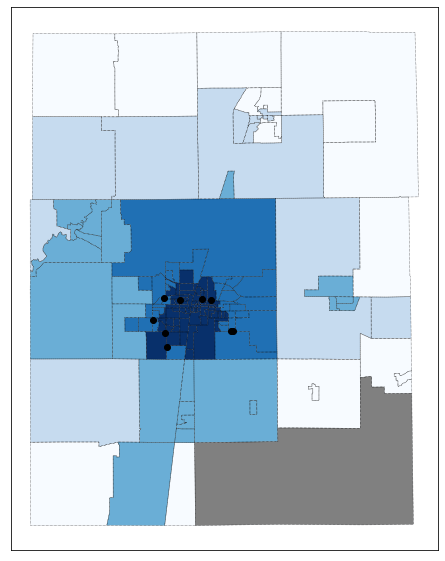

In [11]:
fig, ax = plt.subplots(figsize=(10,10))

supply.plot(ax=ax, zorder=2, color='black')
demand.plot('access', ax=ax, cmap='Blues', scheme='FisherJenks', zorder=1)
demand.loc[demand['access'] == 0].plot(ax=ax, color='grey', zorder=1)
demand.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=2)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

# 3. Calculate spatial autocorrelation based on the accessibility measure (2 points)

Calculate **Moran's I** and **Local Moran's I** based on the accessibility measures. If you fail to finish the accessibility measurements, you can use `step2.shp` in the data folder for this task. 

* Compute weights (`w`) with `libpysal.weights.DistanceBand`, which will be utilized for calculating spatial autocorrelation. 
* Fixed distance will be 10000 and alpha value for distance decay is -1.  

If you are looking for places to search, visit <a href=https://pysal.org/libpysal/generated/libpysal.weights.DistanceBand.html>`libpysal.weights.DistanceBand()`</a>, <a href=https://pysal.org/esda/generated/esda.Moran.html>`esda.Moran()`</a>, <a href=https://pysal.org/esda/generated/esda.Moran_Local.html>`esda.Moran_Local()`</a>. 


## 3.1. Calculate Moran's I of accessibility measure (1 point)

Utilize `esda.moran.Moran()` and print the `Moran's I`.

In [12]:
# Your code here
dist = 10000 # distance band
alpha_val = -1 # the power of distance decay function, should be negative value. 

# Obtain coordinates of each geographical units
coords = demand.apply(lambda x:x.geometry.centroid.coords[0], axis=1).values

# Calculate weights of each geographical units based on distance decay method. 
w = libpysal.weights.DistanceBand(data=list(coords), # coordinates of each geographical units
                                  threshold=dist, # distance band
                                  binary=False, # whether distance decay is employed or not. 
                                  alpha=alpha_val, # distance decay parameter for weight (default -1.0)
                                  silence_warnings=False
                                 )

# Focused variable
y = demand['access']

# Calculate Moran's I
mi = esda.moran.Moran(y, w)
print(mi.I)

0.8098445244523347


/Users/jparkgeo/opt/anaconda3/envs/sa/lib/python3.8/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


## 3.2. Calculate Local Moran's I (1 point)

Utilize `esda.moran.Moran_Local()` function and plot the Local Moran's I result as shown below. Use the following code to color your result if the classification is statistically significant (p-value < 0.05). 

```python
lm_dict = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'lightgrey'}
```

**Note**: The map can be slightly different for every run, since the equation is based on a simulation.

<img src="./images/lisa.jpg" height="50%"/>

/Users/jparkgeo/opt/anaconda3/envs/sa/lib/python3.8/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


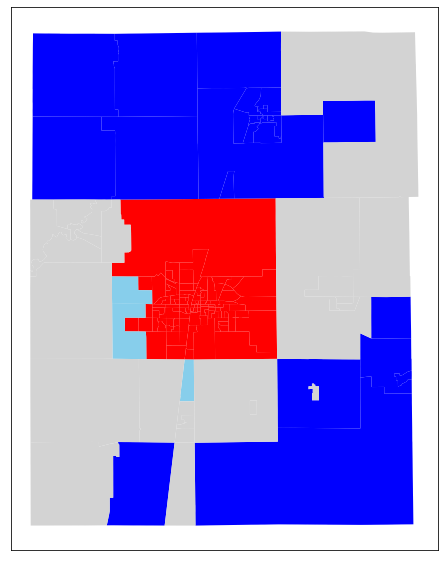

In [13]:
# Calculate Local Moran's I
lm = esda.moran.Moran_Local(y, w)

# Assign the classification of LISA based on their significance level. 
lm_dict = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
lisa = []
for idx in range(len(lm.q)):
    if lm.p_sim[idx] < 0.05:
        lisa.append(lm_dict[lm.q[idx]])
    else:
        lisa.append('Not_Sig')
        
lisa = pd.Series(lisa)
demand['fixed'] = lisa

# Plotting 
lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'lightgrey'}

fig, ax = plt.subplots(figsize=(10, 10))
for key in lisa_color.keys():
    demand.loc[demand['fixed'] == key].plot(ax=ax, color=lisa_color[key], legend=True)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()